# Data Cleaning 

In [191]:
import pandas as pd
df = pd.read_csv('data-pozo/kc_house_data.csv')

In [192]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [193]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 0 to 30154
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30111 non-null  int64         
 1   date           30111 non-null  datetime64[ns]
 2   price          30111 non-null  float64       
 3   bedrooms       30111 non-null  int64         
 4   bathrooms      30111 non-null  float64       
 5   sqft_living    30111 non-null  int64         
 6   sqft_lot       30111 non-null  int64         
 7   floors         30111 non-null  float64       
 8   waterfront     30111 non-null  object        
 9   greenbelt      30111 non-null  object        
 10  nuisance       30111 non-null  object        
 11  view           30111 non-null  object        
 12  condition      30111 non-null  object        
 13  grade          30111 non-null  object        
 14  heat_source    30111 non-null  object        
 15  sewer_system   3011

In [195]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [196]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)


In [197]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]

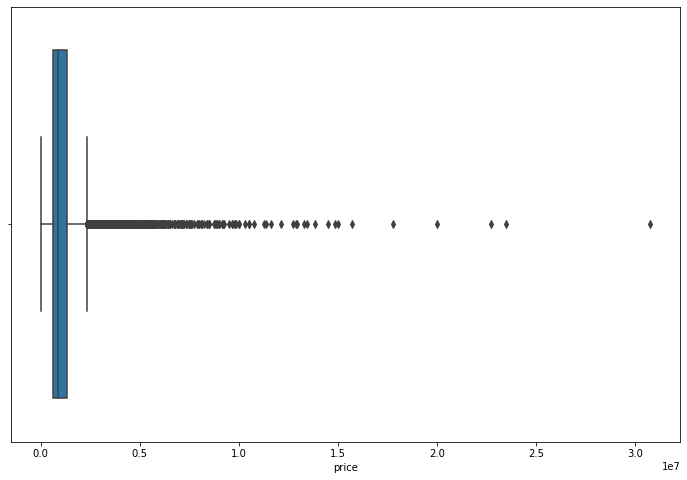

In [207]:
#Visualize price to find outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x = df['price'])
plt.show()



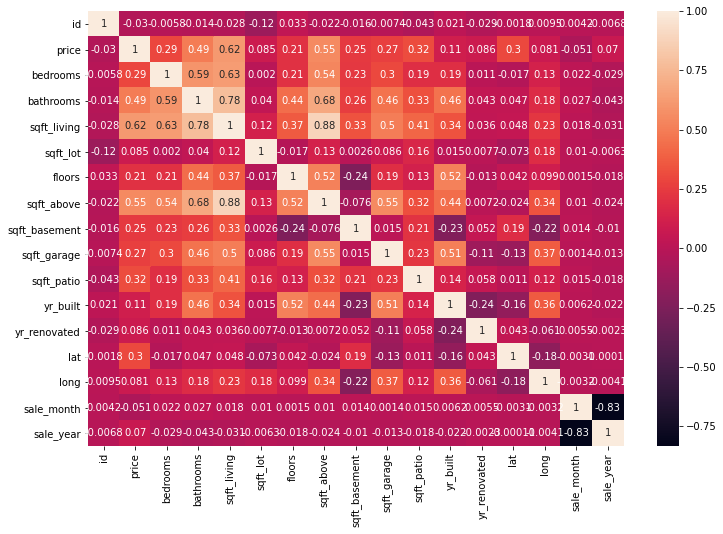

In [210]:
#Run heatmap to identify variables most correlated with price 
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot = True)
plt.show();

# sqft_living most correlated with price, use as single variable base model

# Creating Base Model 

In [218]:
# Run train-test split to create test and control group

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import numpy as np

X = df['sqft_living'].values.reshape(-1,1)
y = df['price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_t)

#baseline r-squared value is .3422  



0.3422830933088098

# Model 1: Multi-Linear using select numeric columns and standard scalar

In [226]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)
dict(zip(X_train.columns, model.coef_))



{'bedrooms': -158497.10518824,
 'bathrooms': 124780.75324626453,
 'sqft_living': 324730.3402216628,
 'sqft_lot': -6643.678985736453,
 'floors': -21592.171492147747,
 'sqft_above': 288256.01893072703,
 'sqft_basement': 100417.10771529572,
 'sqft_garage': -39851.45782791007,
 'sqft_patio': 58295.625528123855,
 'yr_built': -107553.01800280582,
 'yr_renovated': 24896.265059943726,
 'sale_month': 37796.09200874684,
 'sale_year': 109634.44212145582}

In [223]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

import statsmodels.api as sm
model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model_OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     1168.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        17:46:12   Log-Likelihood:            -2.8755e+05
No. Observations:               19410   AIC:                         5.751e+05
Df Residuals:                   19395   BIC:                         5.752e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.117e+06   4717.501    236.826      0.000    1.11e+06    1.13e+06
x1         -2397.4719   4763.825     -0.503      0.615   -1.17e+04    6940.035
x2         -1.585e+05   6348.044    -24.967      0.000   -1.71e+05   -1.46e+05
x3          1.247e+05   8722.528     14.299      0.000    1.08e+05    1.42e+05
x4          3.248e+05   2.12e+04     15.347      0.000    2.83e+05    3.66e+05
x5         -6921.6418   4872.784     -1.420      0.155   -1.65e+04    2629.436
x6         -2.145e+04   6546.906     -3.277      0.001   -3.43e+04   -8621.491
x7          2.881e+05   1.94e+04     14.863      0.000     2.5e+05    3.26e+05
x8          1.004e+05   9510.551     10.560      0.000    8.18e+04    1.19e+05
x9          -3.98e+04   6487.945     -6.135      0.000   -5.25e+04   -2.71e+04
x10         5.824e+04   5252.502     11.088      0.000    4.79e+04    6.85e+04
x11        -1.075e+05   7029.768    -15.298      0.000   -1.21e+05   -9.38e+04
x12         2.483e+04   4982.637      4.984      0.000    1.51e+04    3.46e+04
x13         3.781e+04   8559.800      4.418      0.000     2.1e+04    5.46e+04
x14         1.096e+05   8563.823     12.800      0.000    9.28e+04    1.26e+05
==============================================================================
Omnibus:                    24110.548   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11762162.753
Skew:                           6.317   Prob(JB):                         0.00
Kurtosis:                     122.933   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""